In [139]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor as skGBR, RandomForestRegressor as skRFR
from xgboost import XGBRegressor
import lightgbm as lgb

import statsmodels.api as sm

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [2]:
df_train = pd.read_csv('train.csv',index_col='Id')
df_test = pd.read_csv('test.csv',index_col='Id')
df_all = pd.concat([df_train.drop('SalePrice',axis=1),df_test])

In [3]:
print(df_train.shape)
print(df_test.shape)

(1460, 80)
(1459, 79)


In [4]:
''' Columns of categorical features. Columns with object type and 3 cols of int categories'''
cat_cols = [col for col in df_train.columns if df_train[col].dtype == 'object'] + ['MSSubClass', 'OverallQual','OverallCond']

In [5]:
df_train[cat_cols]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass,OverallQual,OverallCond
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,TA,Y,NaN,NaN,NaN,WD,Normal,60,7,5
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,TA,Y,NaN,NaN,NaN,WD,Normal,20,6,8
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,TA,Y,NaN,NaN,NaN,WD,Normal,60,7,5
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,TA,Y,NaN,NaN,NaN,WD,Abnorml,70,7,5
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,TA,Y,NaN,NaN,NaN,WD,Normal,60,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,TA,Y,NaN,NaN,NaN,WD,Normal,60,6,5
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,TA,Y,NaN,MnPrv,NaN,WD,Normal,20,6,6
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,TA,Y,NaN,GdPrv,Shed,WD,Normal,70,7,9


In [6]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (round(total/data.shape[0]*100,2)).sort_values(ascending = False)
    df_missing = pd.concat([total, percent, data.dtypes, data.nunique(dropna=True)], axis=1, keys=['total', 'percent','dtype','nunique'])
    return df_missing[df_missing.total > 0]

In [7]:
missing_data(df_all)

,total,percent,dtype,nunique
PoolQC,2909,99.66,object,3
MiscFeature,2814,96.40,object,4
Alley,2721,93.22,object,2
Fence,2348,80.44,object,4
FireplaceQu,1420,48.65,object,5
LotFrontage,486,16.65,float64,128
GarageYrBlt,159,5.45,float64,103
GarageFinish,159,5.45,object,3
GarageQual,159,5.45,object,5
GarageCond,159,5.45,object,5


# Cleaning

Cleaning and unifying the categories of the object features.

In [8]:
for col in cat_cols:
    print(col, df_all[col].unique(), '\n')

MSZoning ['RL' 'RM' 'C (all)' 'FV' 'RH' nan] 

Street ['Pave' 'Grvl'] 

Alley [nan 'Grvl' 'Pave'] 

LotShape ['Reg' 'IR1' 'IR2' 'IR3'] 

LandContour ['Lvl' 'Bnk' 'Low' 'HLS'] 

Utilities ['AllPub' 'NoSeWa' nan] 

LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3'] 

LandSlope ['Gtl' 'Mod' 'Sev'] 

Neighborhood ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste'] 

Condition1 ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe'] 

Condition2 ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe'] 

BldgType ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs'] 

HouseStyle ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin'] 

RoofStyle ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed'] 

RoofMatl ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTil

In [9]:
def clean(df):
    
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})    
    # Some values of GarageYrBlt are corrupt (is Nan), so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

------------------

# Processing of the categorical variables

In [10]:
''' There are many cat. features with 5 and 10 levels'''
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

In [11]:
five_cols = [col for col in cat_cols if len(set(df_all[col].unique()) - set(five_levels)) <=1]
print(five_cols)
ten_cols = [col for col in cat_cols if len(set(df_all[col].unique()) - set(ten_levels)) <=1]
print(ten_cols)

['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
['OverallQual', 'OverallCond']


In [12]:
# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood","Condition1",
                "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st","Exterior2nd", 
                "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

--------------

In [13]:
''' Handle Missing Values'''

def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

## Load data

In [14]:
def load_data():
    # Read data
    df_train = pd.read_csv("train.csv", index_col="Id")
    df_test = pd.read_csv("test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test.drop('SalePrice',axis=1)

In [15]:
df_train, df_test = load_data()

/home/jose/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [16]:
df_train.shape

(1460, 80)

In [17]:
df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2007,WD,Normal,175000.0
1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,2,2010,WD,Normal,210000.0
1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500.0


# Baseline

Calculating the baseline model on unmodified features

In [18]:
X = df_train.copy()
y = X.pop('SalePrice')

feat_names = X.columns.to_list()
cat_names = X.select_dtypes(["category"]).columns.to_list()

In [19]:
def score_dataset(X, y, model):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    XX = X.copy()
    
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    
    if type(model).__name__ != 'LGBMRegressor':
        for colname in X.select_dtypes(["category"]):
            XX[colname] = X[colname].cat.codes # Label endoding               
    else:
        XX = X.copy() # LGB doesn't need to encode the categorical features
        
    score = cross_val_score(
        model, XX, log_y, cv=5, scoring="neg_mean_squared_error",
        )   
        
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [20]:
''' Only tree based models will be studied'''

baseline_models = [XGBRegressor(),skGBR(),skRFR(),lgb.LGBMRegressor()]

base_results = {type(model).__name__ : score_dataset(X,y,model) for model in baseline_models}
base_results

{'XGBRegressor': 0.14351093866598752,
 'GradientBoostingRegressor': 0.12658025616773608,
 'RandomForestRegressor': 0.13935605328784298,
 'LGBMRegressor': 0.12989380627189986}

-------------------

# Future Utility Score (Mutual information)

In [21]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    bar_width = scores.sort_values(ascending=True)
    y_coordinates = np.arange(len(scores))
    ticks = list(scores.sort_values(ascending=True).index)
    plt.figure(figsize=(15,15))
    plt.barh(y_coordinates, bar_width)
    plt.yticks(y_coordinates, ticks)
    plt.title("Mutual Information Scores")

In [22]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores[mi_scores > 0].index

Index(['OverallQual', 'Neighborhood', 'GrLivArea', 'YearBuilt', 'LotArea',
       'TotalBsmtSF', 'GarageArea', 'GarageCars', 'BsmtQual', 'KitchenQual',
       'ExterQual', 'FirstFlrSF', 'MSSubClass', 'YearRemodAdd', 'GarageYrBlt',
       'FullBath', 'GarageFinish', 'LotFrontage', 'FireplaceQu', 'GarageType',
       'TotRmsAbvGrd', 'Foundation', 'OpenPorchSF', 'Fireplaces',
       'SecondFlrSF', 'HeatingQC', 'Exterior2nd', 'BsmtFinSF1', 'BsmtFinType1',
       'Exterior1st', 'MSZoning', 'BsmtUnfSF', 'OverallCond', 'WoodDeckSF',
       'MasVnrType', 'MasVnrArea', 'LotShape', 'HouseStyle', 'HalfBath',
       'SaleCondition', 'SaleType', 'GarageCond', 'BsmtExposure', 'GarageQual',
       'BedroomAbvGr', 'CentralAir', 'BsmtCond', 'PavedDrive', 'Electrical',
       'Fence', 'BldgType', 'BsmtFinType2', 'LandContour', 'Alley',
       'ScreenPorch', 'EnclosedPorch', 'KitchenAbvGr', 'ExterCond',
       'Condition1', 'Heating', 'BsmtHalfBath', 'LotConfig', 'RoofStyle',
       'BsmtFinSF2', 'BsmtFu

In [23]:
mi_scores

OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
                  ...   
PoolQC          0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI Scores, Length: 79, dtype: float64

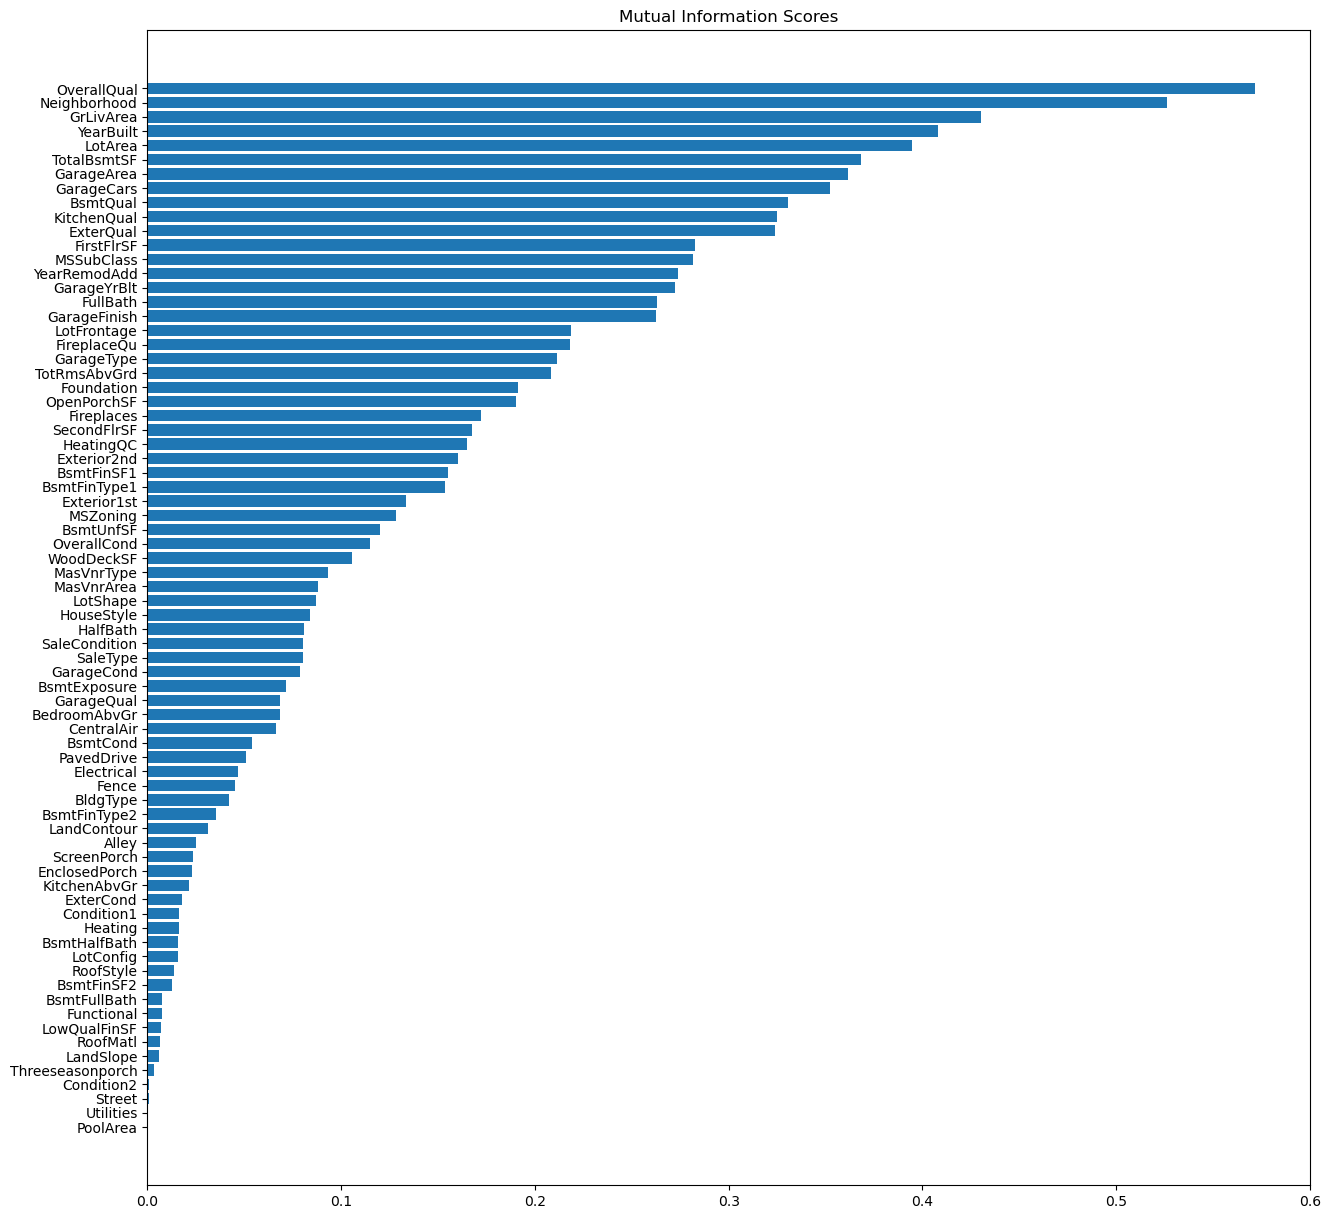

In [24]:
plot_mi_scores(mi_scores[mi_scores > 0])

In [25]:
def drop_uninformative(df, mi_scores, mi_min = 0.0):
    return df.loc[:, mi_scores > mi_min]

In [26]:
X = df_train.copy()
y = X.pop("SalePrice")

X = drop_uninformative(X, mi_scores)

no_mi_zeros_results = {type(model).__name__ : score_dataset(X,y,model) for model in baseline_models}
no_mi_zeros_results

{'XGBRegressor': 0.14338026718687277,
 'GradientBoostingRegressor': 0.12720872453207818,
 'RandomForestRegressor': 0.13927434098549296,
 'LGBMRegressor': 0.12844071720047118}

In [27]:
base_results

{'XGBRegressor': 0.14351093866598752,
 'GradientBoostingRegressor': 0.12658025616773608,
 'RandomForestRegressor': 0.13935605328784298,
 'LGBMRegressor': 0.12989380627189986}

In [28]:
# Advantages achieved
{key : base_results[key] - no_mi_zeros_results[key] for key in base_results}

{'XGBRegressor': 0.00013067147911474675,
 'GradientBoostingRegressor': -0.0006284683643421052,
 'RandomForestRegressor': 8.17123023500177e-05,
 'LGBMRegressor': 0.001453089071428687}

# Feature creation

## Math feature transformation

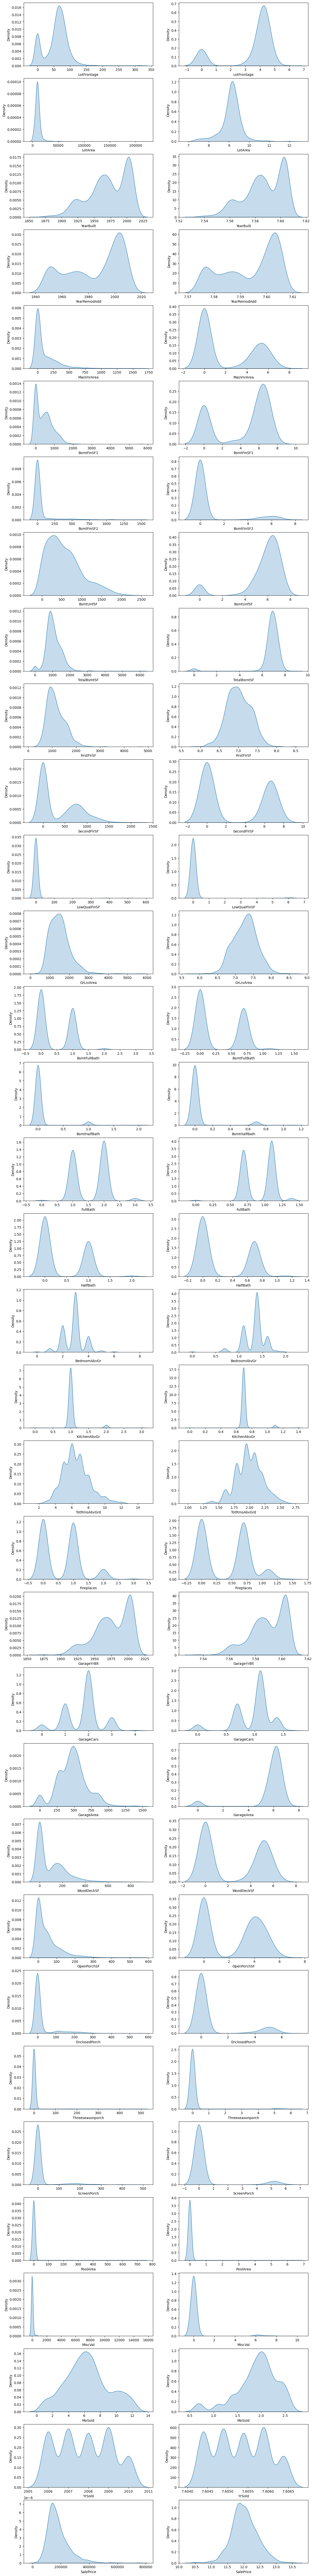

In [29]:
'''The plots to find out which features need a log transformation'''
numeric_cols = df_train.select_dtypes(['number']).columns
fig, axs = plt.subplots(len(numeric_cols), 2, figsize=(15, 4*len(numeric_cols)))

for i, col in enumerate(numeric_cols):   
    sns.kdeplot(df_train[col], fill=True, ax=axs[i,0])
    sns.kdeplot(df_train[col].apply(np.log1p), fill=True, ax=axs[i,1])

In [30]:
cols_to_log1p = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','FirstFlrSF','SecondFlrSF','WoodDeckSF','OpenPorchSF']
mi_scores[cols_to_log1p]

LotFrontage    0.218588
LotArea        0.394468
MasVnrArea     0.088054
BsmtFinSF1     0.154940
BsmtFinSF2     0.012719
BsmtUnfSF      0.119885
TotalBsmtSF    0.368536
FirstFlrSF     0.282503
SecondFlrSF    0.167590
WoodDeckSF     0.105387
OpenPorchSF    0.190266
Name: MI Scores, dtype: float64

In [31]:
area_feat = ['GrLivArea','WoodDeckSF','MasVnrArea','TotalBsmtSF']
mi_scores[area_feat]

GrLivArea      0.430395
WoodDeckSF     0.105387
MasVnrArea     0.088054
TotalBsmtSF    0.368536
Name: MI Scores, dtype: float64

In [32]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    # This feature ended up not helping performance
    #X["TotalOutsideSF"] = df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + df.Threeseasonporch + df.ScreenPorch
    #X['Overall_QualCond'] = df[['OverallQual','OverallCond']].replace({'None':0}).to_numpy().prod(axis=1)
    return X

def log1p_transform(df, cols):
    X = df[cols].apply(np.log1p)
    X.columns = [col + '_log1p' for col in cols]
    return X

def area_root(df, cols):
    X = df[cols].apply(np.sqrt)
    X.columns = [col + '_sqrt' for col in cols]
    return X

def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X

# One-hot encoding: 
def onehot(df, num, onehot_cols = None):
    X = pd.DataFrame(index=df.index)
    if not onehot_cols:
        onehot_cols = [col for col in df.select_dtypes(['category']) if (df[col].nunique() < num) & (df[col].nunique() > 2) & (mi_scores[col] > 0) ]
    for col in onehot_cols:
        X = X.join(pd.get_dummies(df[col], prefix=col))
    return X #, onehot_cols

def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


#def break_down(df):
#    X = pd.DataFrame()
#    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
#    return X


def group_transforms(df):
    ''' There are too high correlations of Max with Std and counts of Lot and Ground consequently'''
    X = pd.DataFrame()
    X[["MedNhbdGrArea","MedNhbdLotArea"]] = df.groupby("Neighborhood")[["GrLivArea","LotArea"]].transform("median")
    X[["MinNhbdGrArea","MinNhbdLotArea"]] = df.groupby("Neighborhood")[["GrLivArea","LotArea"]].transform("min")
    #X[["MaxNhbdGrArea","MaxNhbdLotArea"]] = df.groupby("Neighborhood")[["GrLivArea","LotArea"]].transform("max")
    X[["StdNhbdGrArea","StdNhbdLotArea"]] = df.groupby("Neighborhood")[["GrLivArea","LotArea"]].transform("std")
    X["CountNhbdGrArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("count")
    return X

<AxesSubplot:>

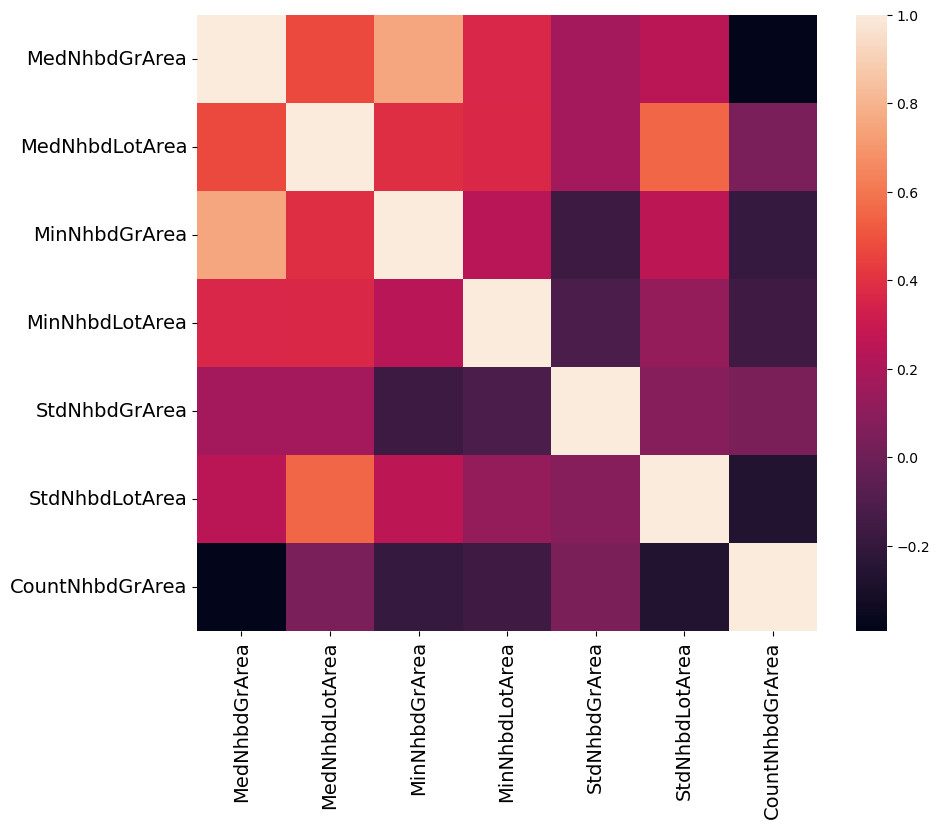

In [33]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.heatmap(group_transforms(df_train).corr())


In [34]:
def create_features(df):
    X = df.copy()
    y = X.pop("SalePrice")
    X = X.join(mathematical_transforms(X))
    X = X.join(log1p_transform(X,cols_to_log1p))
    X = X.join(area_root(X,area_feat))
    X = X.join(interactions(X))
    #df_onehot, onehot_cols = onehot(X,10)
    #X = X.drop(onehot_cols,axis=1).join(df_onehot)
    X = X.join(onehot(X,10))
    X = X.join(counts(X))
    X = X.join(group_transforms(X))
    return X, y

In [35]:
X, y = create_features(df_train)

new_features_mi_scores = make_mi_scores(X, y)

X = drop_uninformative(X, new_features_mi_scores)

new_features_results = {type(model).__name__ : score_dataset(X,y,model) for model in baseline_models}
new_features_results

{'XGBRegressor': 0.1351856367192639,
 'GradientBoostingRegressor': 0.12479247661209632,
 'RandomForestRegressor': 0.13790160216259545,
 'LGBMRegressor': 0.12850859719498384}

## Removing correlating features

In [36]:
def drop_correlated(df, crit_corr=0.9, upper=True):
    corr_matrix = X.corr().abs()
    if upper:
        half_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    else:
        half_corr = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))
        
    cols_to_drop = [column for column in half_corr.columns if any(half_corr[column] > crit_corr)]
        
    return df.drop(cols_to_drop, axis=1)

In [37]:
X, y = create_features(df_train)

X = drop_correlated(X)

new_features_mi_scores = make_mi_scores(X, y)
X = drop_uninformative(X, new_features_mi_scores)

results_pandas_feat_no_corr_upper = {type(model).__name__ : score_dataset(X,y,model) for model in baseline_models}
results_pandas_feat_no_corr_upper

{'XGBRegressor': 0.13511114424712925,
 'GradientBoostingRegressor': 0.12535708925468617,
 'RandomForestRegressor': 0.13791441338675592,
 'LGBMRegressor': 0.1303974421482188}

In [38]:
''' Some features in correlated pairs may be more informative than others. 
    That's why I test upper and lower triangular matrix when filtering features.'''
X, y = create_features(df_train)

X = drop_correlated(X,upper=False)
new_features_mi_scores = make_mi_scores(X, y)
X = drop_uninformative(X, new_features_mi_scores)

results_pandas_feat_no_corr_lower_09 = {type(model).__name__ : score_dataset(X,y,model) for model in baseline_models}
results_pandas_feat_no_corr_lower_09

{'XGBRegressor': 0.13644156692471188,
 'GradientBoostingRegressor': 0.12432198214210438,
 'RandomForestRegressor': 0.13786389218379036,
 'LGBMRegressor': 0.12967554375581114}

-----------------

# k-Means

In [39]:
cluster_features_basic = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    X_new.index = X.index
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    X_cd.index = X.index
    return X_cd

In [40]:
X, y = create_features(df_train)

X = drop_correlated(X)

new_features_mi_scores = make_mi_scores(X, y)
X = drop_uninformative(X, new_features_mi_scores)

In [41]:
%%time
cluster_features = X.loc[:,new_features_mi_scores > 0.35].select_dtypes('number').columns
X_cluster = cluster_labels(X,cluster_features_basic, n_clusters=6)
X = X.join(X_cluster)

results_kmeans = {type(model).__name__ : score_dataset(X,y,model) for model in baseline_models}

CPU times: user 1min 4s, sys: 831 ms, total: 1min 5s
Wall time: 17.9 s


In [42]:
results_kmeans

{'XGBRegressor': 0.13563515556050243,
 'GradientBoostingRegressor': 0.12647974772612453,
 'RandomForestRegressor': 0.13858411177862726,
 'LGBMRegressor': 0.1294768860709357}

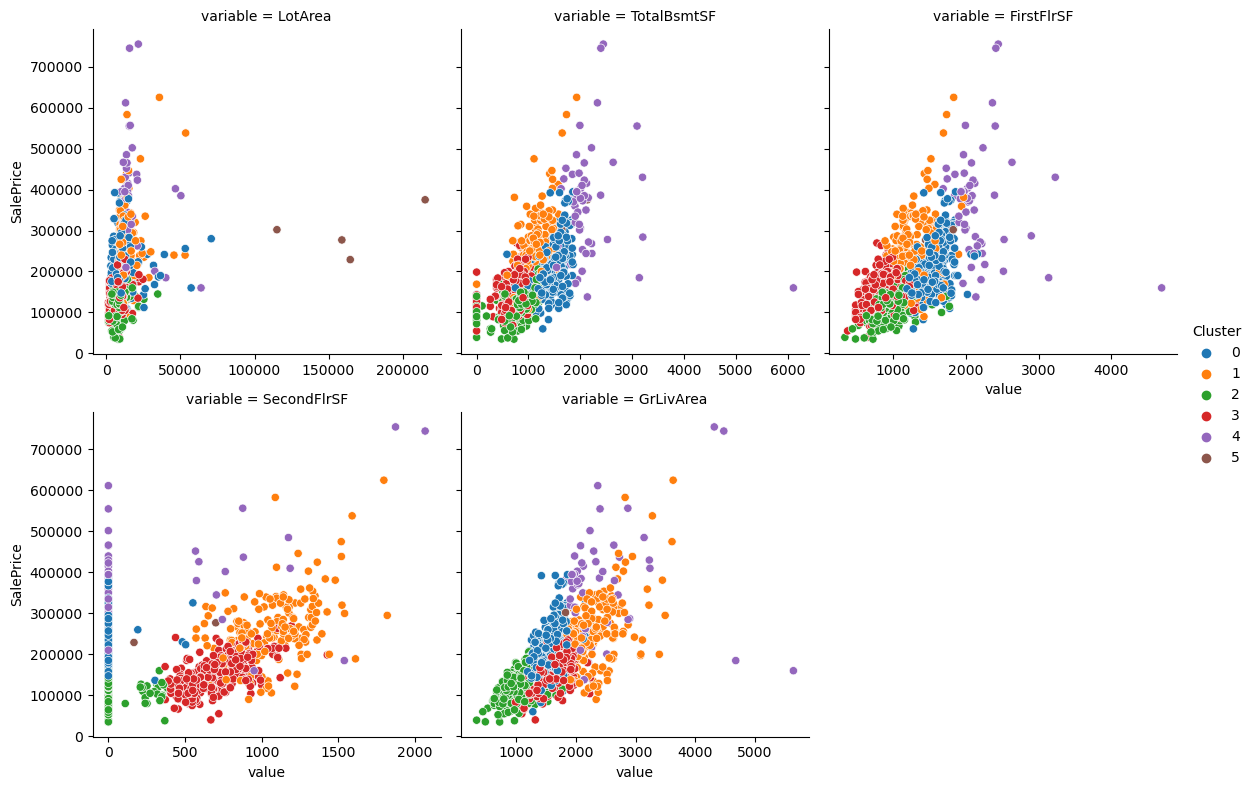

In [43]:
Xy = X.copy()
Xy["Cluster"] = Xy.Cluster.astype("category")
Xy["SalePrice"] = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    data=Xy.melt(
        value_vars=cluster_features_basic, id_vars=["SalePrice", "Cluster"],
    ),
);

In [44]:
def cluster_inertia(df, features, cluster_range=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    inertia = []
    
    for k in range(1, class_range):
        kmeans = KMeans(n_clusters=k,  n_init=50, random_state=0).fit(X_scaled)
        inertia.append(np.sqrt(kmeans.inertia_))
   
    return inertia

CPU times: user 5min 26s, sys: 9.26 s, total: 5min 35s
Wall time: 23.4 s


Text(0, 0.5, '$J(C_k)$')

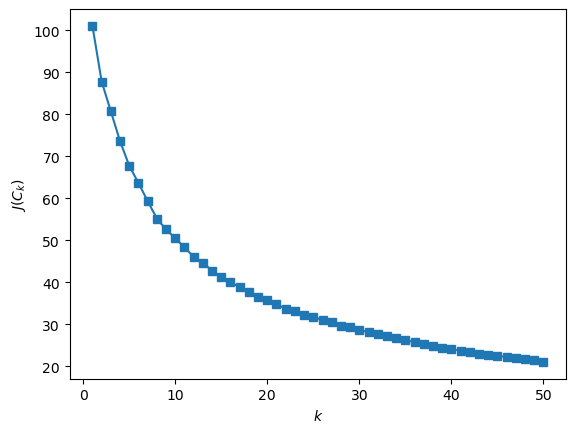

In [45]:
%%time 
class_range = 51

X, y = create_features(df_train)
X = drop_correlated(X)

new_features_mi_scores = make_mi_scores(X, y)
X = drop_uninformative(X, new_features_mi_scores)

cluster_features = X.loc[:,new_features_mi_scores > 0.4].select_dtypes('number').columns    
inertia = cluster_inertia(X, cluster_features, class_range)

plt.plot(range(1, class_range), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

## Cluster distance

In [46]:
X, y = create_features(df_train)

X = drop_correlated(X)

new_features_mi_scores = make_mi_scores(X, y)
X = drop_uninformative(X, new_features_mi_scores)

In [47]:
%%time
cluster_features = X.loc[:,new_features_mi_scores > 0.3].select_dtypes('number').columns
X_cd = cluster_distance(X,cluster_features,n_clusters=6)
X = X.join([X_cluster, X_cd])

results_kmeans_dist = {type(model).__name__ : score_dataset(X,y,model) for model in baseline_models}

CPU times: user 1min 16s, sys: 895 ms, total: 1min 17s
Wall time: 23.5 s


In [48]:
results_kmeans_dist

{'XGBRegressor': 0.13559842798990265,
 'GradientBoostingRegressor': 0.12843508829039238,
 'RandomForestRegressor': 0.14214085988917902,
 'LGBMRegressor': 0.12935143512181962}

----------------------

# PCA

In [49]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names,index=X.index)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=width, dpi=dpi)
    return axs

# Features inspired by PCA analysis results
def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


features_pca_basic = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

In [50]:
X_pca_inspired = pca_inspired(df_train)

In [51]:
#X, y = create_features(df_train)
X = df_train.copy()
y = X.pop('SalePrice')

X = drop_correlated(X)

new_features_mi_scores = make_mi_scores(X, y)
X = drop_uninformative(X, new_features_mi_scores)

feat_pca = X.loc[:,new_features_mi_scores > 0.0].select_dtypes('number')
pca, X_pca, loadings = apply_pca(feat_pca)
#pca, X_pca, loadings = apply_pca(X[features_pca_basic])

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

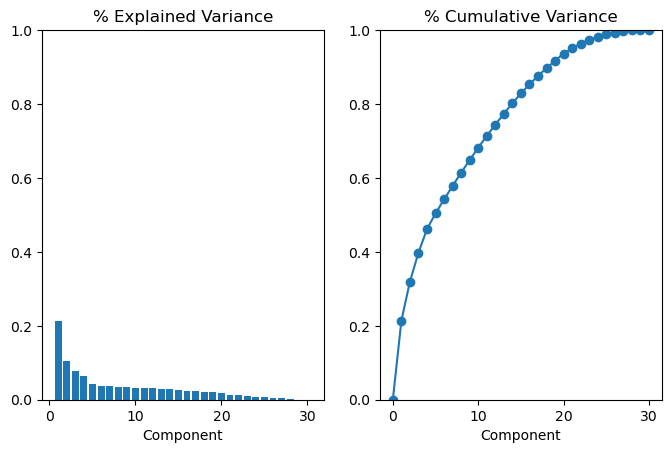

In [52]:
plot_variance(pca)

In [53]:
results_clearPCA = {type(model).__name__ : score_dataset(X_pca,y,model) for model in baseline_models}
results_clearPCA

{'XGBRegressor': 0.16915349023425094,
 'GradientBoostingRegressor': 0.16005304466027778,
 'RandomForestRegressor': 0.16156405645494193,
 'LGBMRegressor': 0.16054961386175506}

In [54]:
X_pca.iloc[:,:28].shape

(1460, 28)

In [55]:
X_all = X.join([X_cluster, X_cd, X_pca.iloc[:,:28],X_pca_inspired])

feat_mi_info = make_mi_scores(X_all,y)
X_all = drop_uninformative(X_all,feat_mi_info,mi_min=1e-2)
results_plusPCA = {type(model).__name__ : score_dataset(X_all,y,model) for model in baseline_models}
results_plusPCA

{'XGBRegressor': 0.1398007601785313,
 'GradientBoostingRegressor': 0.12521299019624807,
 'RandomForestRegressor': 0.14072528643246726,
 'LGBMRegressor': 0.13107782529354176}

In [56]:
make_mi_scores(X_all,y)

PC1             0.972242
Feature1        0.662653
Centroid_9      0.623414
OverallQual     0.575230
Centroid_5      0.569988
                  ...   
BsmtFullBath    0.014795
Heating         0.014381
LotConfig       0.014266
PC20            0.010897
RoofStyle       0.009880
Name: MI Scores, Length: 110, dtype: float64

In [57]:
X = df_train.copy()
y = X.pop('SalePrice')

{type(model).__name__ : score_dataset(X.join(X_pca_inspired),y,model) for model in baseline_models}

{'XGBRegressor': 0.13859607761626924,
 'GradientBoostingRegressor': 0.12654803375500578,
 'RandomForestRegressor': 0.13960582744921826,
 'LGBMRegressor': 0.1285891178021257}

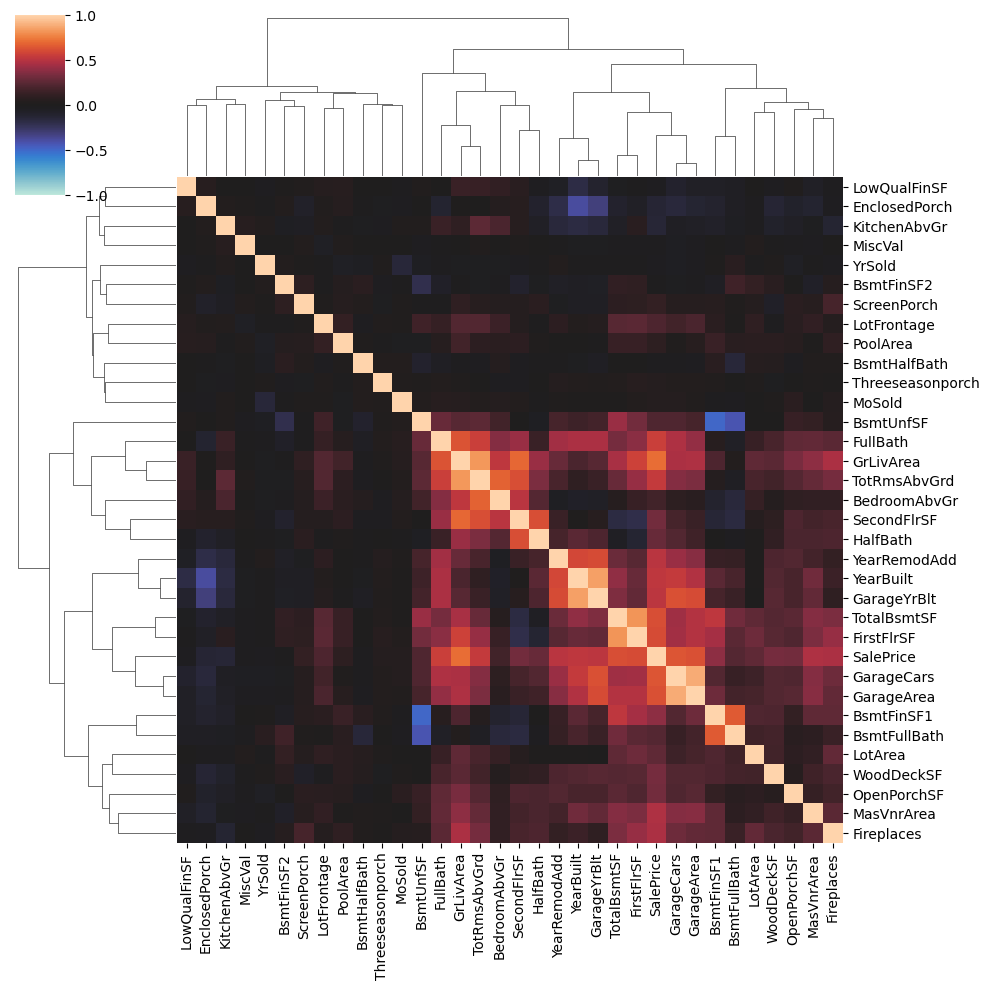

In [58]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)

-------------------

# Outliers

## Manual (visual) outliers detection for PCA vectors

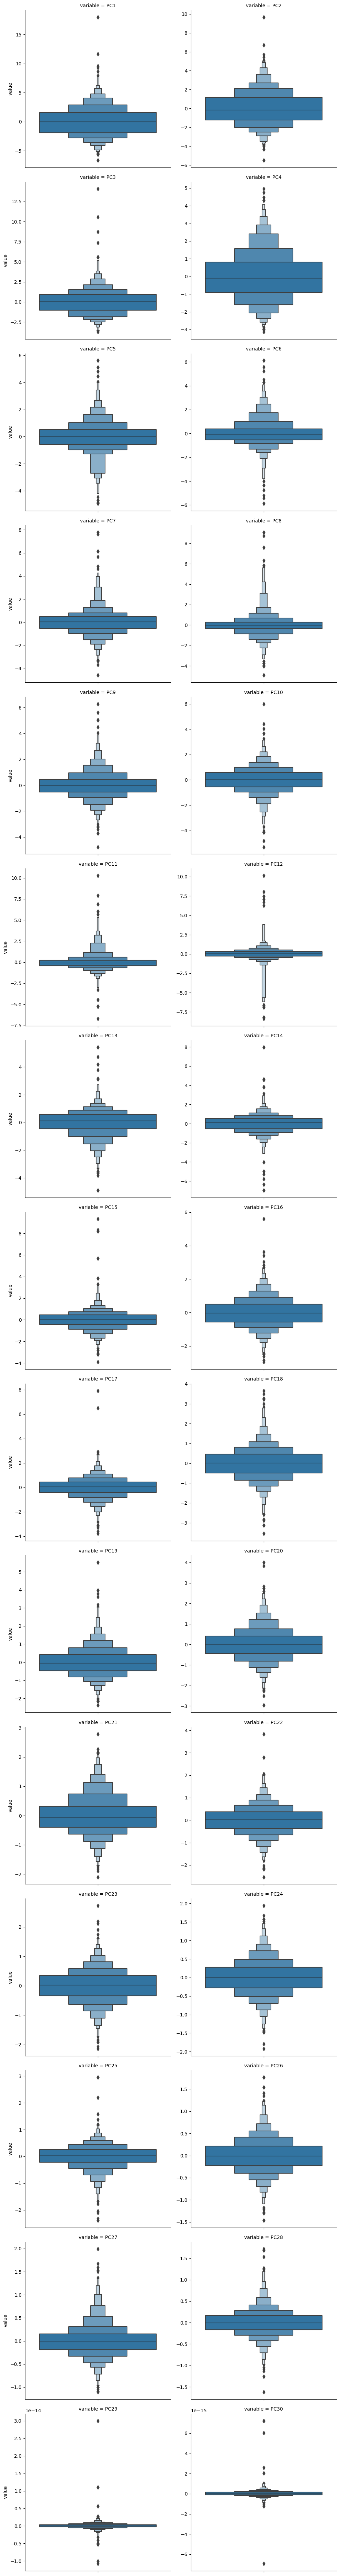

In [59]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2
);

In [60]:
# Boundary (absolute value) between inliers and outliers for each PCA value
d_out = {'PC1':7,'PC2':5,'PC3':5,'PC4':4,'PC5':5,'PC6':4,'PC7':4,'PC8':4,'PC9':4,'PC10':4,
         'PC11':5,'PC12':5,'PC13':4,'PC14':4,'PC15':4,'PC16':3,'PC17':3,'PC18':3,'PC19':3,
         'PC20':3,'PC21':2,'PC22':2,'PC23':2,'PC24':1.5,'PC25':1.5,'PC26':1.5,'PC27':1.5,'PC28':1.5,'PC29':0.5,'PC30':1.5}

In [61]:
idx = set()
out_labels = np.zeros(X_pca.shape[0], int)

for i, comp in enumerate(d_out): 
    s = X_pca[comp].abs().gt(d_out[comp])
    idx  = idx.union(set(s[s].index))
    
    out_labels[[j-1 for j in s[s].index]] = i+1   
    

In [62]:
len(idx)

108

In [63]:
X_all = X.join([X_cluster,X_pca.iloc[:,:28],X_pca_inspired])

{type(model).__name__ : score_dataset(X_all,y,model) for model in baseline_models}

{'XGBRegressor': 0.14437675376977332,
 'GradientBoostingRegressor': 0.12340199345444448,
 'RandomForestRegressor': 0.14031409741485373,
 'LGBMRegressor': 0.12691687223695097}

In [64]:
X_all = X.join([X_cluster,X_pca.iloc[:,:28],X_pca_inspired])

{type(model).__name__ : score_dataset(X_all.drop(idx),y.drop(idx),model) for model in baseline_models}

{'XGBRegressor': 0.13416618311988077,
 'GradientBoostingRegressor': 0.1151691321518141,
 'RandomForestRegressor': 0.13039862074914432,
 'LGBMRegressor': 0.11856037642495808}

In [65]:
X_all = X.join([X_cluster,X_pca.iloc[:,:28],X_pca_inspired])

feat_mi_info = make_mi_scores(X_all,y)
X_all = drop_uninformative(X_all.drop(idx),feat_mi_info)
results_plusPCA = {type(model).__name__ : score_dataset(X_all,y.drop(idx),model) for model in baseline_models}
results_plusPCA

{'XGBRegressor': 0.1343038822339101,
 'GradientBoostingRegressor': 0.11522065412778676,
 'RandomForestRegressor': 0.1309213696189011,
 'LGBMRegressor': 0.11793664449952966}

In [66]:
X_all = X.join([X_cluster,X_pca_inspired])

feat_mi_info = make_mi_scores(X_all,y)
X_all = drop_uninformative(X_all.drop(idx),feat_mi_info)
results_plusPCA = {type(model).__name__ : score_dataset(X_all,y.drop(idx),model) for model in baseline_models}
results_plusPCA

{'XGBRegressor': 0.13124683636396506,
 'GradientBoostingRegressor': 0.11861473601532757,
 'RandomForestRegressor': 0.12884681615989757,
 'LGBMRegressor': 0.1218546441266203}

In [67]:
X_all = X.join([X_cluster,X_pca.iloc[:,:28],X_pca_inspired])


X_all['outliners'] = np.where(out_labels == 0, 0, 1)
{type(model).__name__ : score_dataset(X_all,y,model) for model in baseline_models}

{'XGBRegressor': 0.14514557359426528,
 'GradientBoostingRegressor': 0.12293668669172331,
 'RandomForestRegressor': 0.14088171591562948,
 'LGBMRegressor': 0.12719152710089884}

In [68]:
X_all = X.join([X_cluster,X_pca.iloc[:,:28],X_pca_inspired])

feat_mi_info = make_mi_scores(X_all,y)
X_all = drop_uninformative(X_all,feat_mi_info)
X_all['outliners'] = np.where(out_labels == 0, 0, 1)
{type(model).__name__ : score_dataset(X_all,y,model) for model in baseline_models}

{'XGBRegressor': 0.14501773549429495,
 'GradientBoostingRegressor': 0.12349182474886711,
 'RandomForestRegressor': 0.13953350290074795,
 'LGBMRegressor': 0.1282057302728158}

In [69]:
X_all = X.join([X_cluster,X_pca.iloc[:,:28],X_pca_inspired])

X_all['outliners'] = out_labels
{type(model).__name__ : score_dataset(X_all,y,model) for model in baseline_models}

{'XGBRegressor': 0.1418490886431885,
 'GradientBoostingRegressor': 0.12142351389088295,
 'RandomForestRegressor': 0.14100393874305278,
 'LGBMRegressor': 0.12746522181413314}

In [70]:
X_all = X.join([X_cluster,X_pca.iloc[:,:28],X_pca_inspired])

feat_mi_info = make_mi_scores(X_all,y)
X_all = drop_uninformative(X_all,feat_mi_info)
X_all['outliners'] = out_labels
{type(model).__name__ : score_dataset(X_all,y,model) for model in baseline_models}

{'XGBRegressor': 0.14218777765123658,
 'GradientBoostingRegressor': 0.12246539544750075,
 'RandomForestRegressor': 0.1395667661557813,
 'LGBMRegressor': 0.1286800582329607}

In [71]:
X_all = X.join([X_cluster,X_pca_inspired])

feat_mi_info = make_mi_scores(X_all,y)
X_all = drop_uninformative(X_all,feat_mi_info)
X_all['outliners'] = out_labels
results_plusPCA = {type(model).__name__ : score_dataset(X_all,y,model) for model in baseline_models}
results_plusPCA

{'XGBRegressor': 0.13581258576033153,
 'GradientBoostingRegressor': 0.1279279525771256,
 'RandomForestRegressor': 0.13839941553960208,
 'LGBMRegressor': 0.12801204898588836}

## Cook's distance

In [72]:
def plot_outliers(df, cols, target_col='SalePrice', outlier_col='no_cluster_scaled'):
    
    for colname in df.select_dtypes(["category"]):
        df[colname] = df[colname].cat.codes    
    
    col_scale = int(np.ceil(len(cols)/2))
    
    fig, axs = plt.subplots(col_scale, 2, figsize=(10, col_scale*4), sharey=True)
    #mapdict = {0: [0,0], 1:[0,1], 2:[1,0], 3:[1,1]}

    for n, c in enumerate(cols):
        axs[n//2, n%2].scatter(df[c], df[target_col], c=df[outlier_col], cmap='plasma', vmin=0, vmax=1.5)
        axs[n//2, n%2].set_xlabel(c)

    axs[0,0].set_ylabel(target_col)
    axs[1,0].set_ylabel(target_col)

    plt.show()

In [73]:
def model_test(X,y, calc_cooks=True):
    x = sm.add_constant(X)
    model = sm.OLS(y, x).fit() 

    if calc_cooks:
        np.set_printoptions(suppress=True)
        influence = model.get_influence()
        cooks = influence.cooks_distance
               
    return model, np.nan_to_num(cooks[0])

X, y = create_features(df_train)

X = drop_correlated(X)

new_features_mi_scores = make_mi_scores(X, y)
X = drop_uninformative(X, new_features_mi_scores)

#model, cook_dist = model_test(X.select_dtypes('number'), y)

cols = ['GrLivArea', 'YearBuilt', 'LotArea', 'OverallQual']
model, cook_dist = model_test(X[cols].replace('None', 0).to_numpy(), y)

# Mark as outline data with Cook's distance >= 3*mean(couk_dist)
cdm3 = cook_dist.mean() * 3
X['CooksDist'] = cook_dist
#X['CooksDist'].fillna(0,inplace=True)
X['CooksOut'] = np.where(X['CooksDist'] < cdm3, 0, 1)


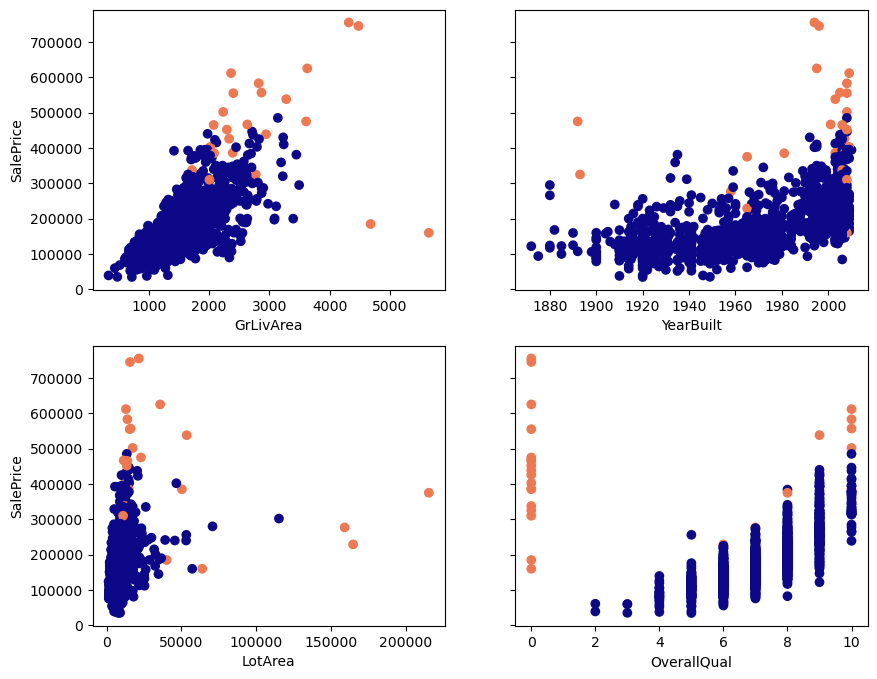

In [74]:
plot_outliers(X.join(y), cols = ['GrLivArea', 'YearBuilt', 'LotArea', 'OverallQual'], outlier_col='CooksOut')

In [75]:
X.CooksOut.sum()

27

In [76]:
{type(model).__name__ : score_dataset(X.drop(['CooksDist','CooksOut'],axis=1),y,model) for model in baseline_models}

{'XGBRegressor': 0.13511114424712925,
 'GradientBoostingRegressor': 0.1249301190262234,
 'RandomForestRegressor': 0.13821192941183255,
 'LGBMRegressor': 0.1303974421482188}

In [77]:
{type(model).__name__ : score_dataset(X,y,model) for model in baseline_models}

{'XGBRegressor': 0.1331405803965355,
 'GradientBoostingRegressor': 0.12353206673632122,
 'RandomForestRegressor': 0.1325857321049442,
 'LGBMRegressor': 0.12355080447124642}

In [78]:
{type(model).__name__ : score_dataset(X.drop('CooksDist', axis=1),y,model) for model in baseline_models}

{'XGBRegressor': 0.13591801652784435,
 'GradientBoostingRegressor': 0.12457999845074218,
 'RandomForestRegressor': 0.1376221194075689,
 'LGBMRegressor': 0.12939847490173753}

In [79]:
{type(model).__name__ : score_dataset(X[X.CooksOut == 0],y[X.CooksOut == 0],model) for model in baseline_models}

{'XGBRegressor': 0.12973895840875646,
 'GradientBoostingRegressor': 0.11699891079344522,
 'RandomForestRegressor': 0.1336905240711605,
 'LGBMRegressor': 0.11757361892106538}

In [80]:
{type(model).__name__ : score_dataset(X[X.CooksOut == 0].drop(['CooksDist','CooksOut'],axis=1),y[X.CooksOut == 0],model) for model in baseline_models}

{'XGBRegressor': 0.13501722866966007,
 'GradientBoostingRegressor': 0.11963674765918286,
 'RandomForestRegressor': 0.13632314690769864,
 'LGBMRegressor': 0.1252018628818633}

## Edwards and Partial

In [81]:
X, y = create_features(df_train)

X = drop_correlated(X)

new_features_mi_scores = make_mi_scores(X, y)
X = drop_uninformative(X, new_features_mi_scores)

X['Edw_Part_out'] = np.where((X.Neighborhood == "Edwards") & (X.SaleCondition == "Partial"), 1, 0)


In [82]:
X.Edw_Part_out.value_counts()

0    1456
1       4
Name: Edw_Part_out, dtype: int64

In [83]:
{type(model).__name__ : score_dataset(X,y,model) for model in baseline_models}

{'XGBRegressor': 0.13525871201081077,
 'GradientBoostingRegressor': 0.12506279540379228,
 'RandomForestRegressor': 0.13792855682652785,
 'LGBMRegressor': 0.1303974421482188}

In [84]:
{type(model).__name__ : score_dataset(X[X.Edw_Part_out == 0],y[X.Edw_Part_out == 0],model) for model in baseline_models}

{'XGBRegressor': 0.1369688733744117,
 'GradientBoostingRegressor': 0.12104668490074376,
 'RandomForestRegressor': 0.13504421952600815,
 'LGBMRegressor': 0.12522630829888617}

## DBSCAN

In [85]:
#dbscan_cols = new_features_mi_scores[:9].index.to_list() + ['SaleCondition']
dbscan_cols = ['GrLivArea', 'YearBuilt', 'LotArea', 'OverallQual','Neighborhood','SaleCondition']

#X[new_features_mi_scores[:20].index]

In [86]:
dbscan_cols

['GrLivArea',
 'YearBuilt',
 'LotArea',
 'OverallQual',
 'Neighborhood',
 'SaleCondition']

(1460, 279)


/home/jose/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


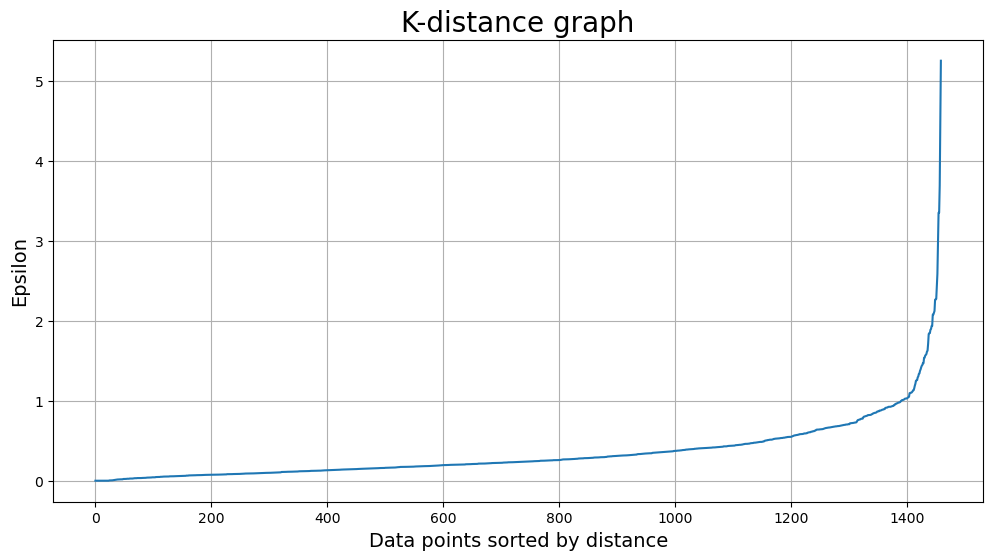

DBSCAN(eps=2.0, min_samples=7)
21
[ 0 -1  1]
CPU times: user 4.29 s, sys: 47.8 ms, total: 4.34 s
Wall time: 2.33 s


In [87]:
%%time

def plot_k_distance_graph(df):
    nn = NearestNeighbors(n_neighbors=2)
    nbrs = nn.fit(df)
    distances, indices = nbrs.kneighbors(df)

    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.figure(figsize=(12,6))
    plt.plot(distances)
    plt.grid()
    plt.title('K-distance graph',fontsize=20)
    plt.xlabel('Data points sorted by distance',fontsize=14)
    plt.ylabel('Epsilon',fontsize=14)
    plt.show()


def run_dbscan(df, data, target_col='SalePrice', eps=8000, min_samples=284, scaled=''):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    print(dbscan)
    
    for colname in df.select_dtypes(["category"]):
        df[colname] = df[colname].cat.codes # Label endoding       

    dbs = dbscan.fit(df)
    clusters = dbs.labels_
    data[f'cluster{scaled}'] = clusters
    data[f'no_cluster{scaled}'] = np.where(data[f'cluster{scaled}'] == -1, 1, 0)

    print(len(data[data[f'cluster{scaled}'] == -1]))
    print(data[f'cluster{scaled}'].unique())
    return data

def scale_data(df):
    
    for col in df.select_dtypes(['category']):
        df[col] = df[col].cat.codes
        
    #df_scaled = StandardScaler().fit_transform(df)
    df_scaled = (df - df.mean())/df.std()
    
    return df_scaled
         
X, y = create_features(df_train)

X = drop_correlated(X)

new_features_mi_scores = make_mi_scores(X, y)
X = drop_uninformative(X, new_features_mi_scores)

print(X.shape)

df = X[dbscan_cols] #.join(y) #.replace('None',0).astype(int)
#df_scaled = StandardScaler().fit_transform(df)

df_scaled = scale_data(df)

# calculate epsilon using the K-distance graph
plot_k_distance_graph(df_scaled)

K_min_samples = df_scaled.shape[1] + 1
# run DBSCAN and return the data with cluster columns
X = run_dbscan(df_scaled, X, eps=2.0, min_samples=K_min_samples, scaled='_scaled')
#print(X.shape)

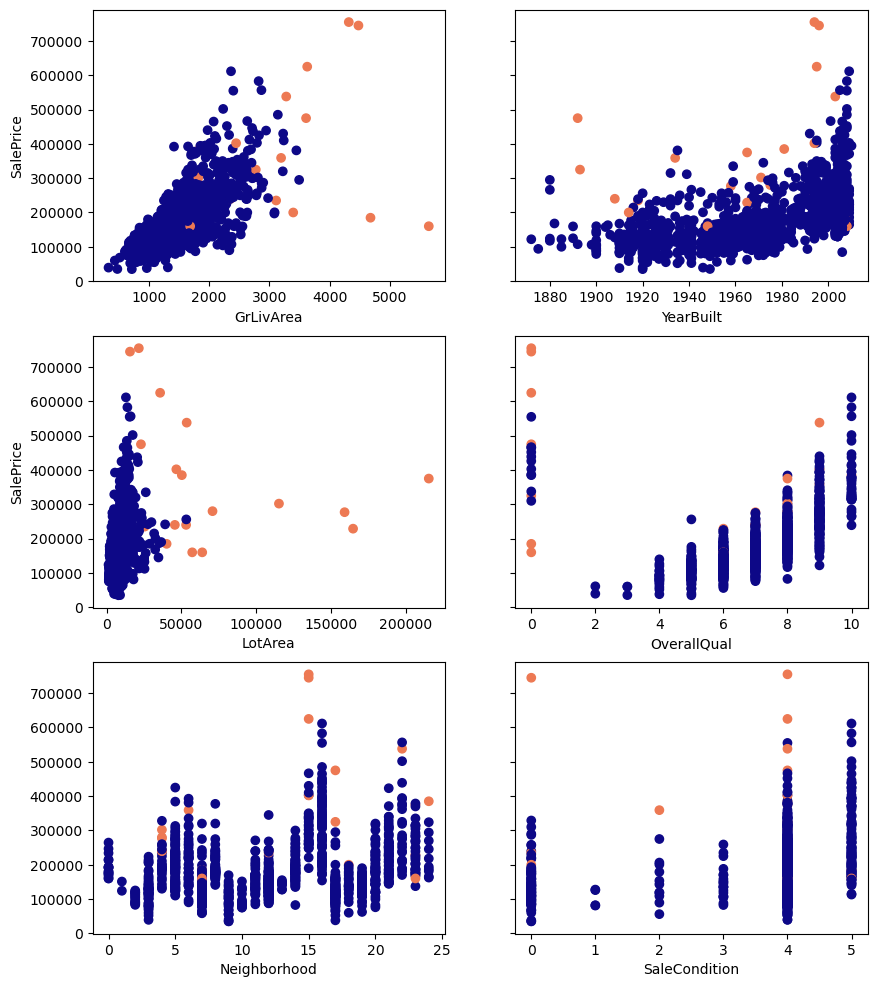

In [88]:
plot_outliers(X[dbscan_cols].join(y).join(X['no_cluster_scaled']),dbscan_cols)

In [89]:
X.no_cluster_scaled.value_counts()

0    1439
1      21
Name: no_cluster_scaled, dtype: int64

In [90]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PorchTypes,MedNhbdGrArea,MedNhbdLotArea,MinNhbdGrArea,MinNhbdLotArea,StdNhbdGrArea,StdNhbdLotArea,CountNhbdGrArea,cluster_scaled,no_cluster_scaled
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,1,1500.0,9356.0,768.0,4426.0,430.932464,2344.775545,150,0,0
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,1,1437.0,11120.0,1208.0,9549.0,313.984481,11832.672851,11,0,0
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,1,1500.0,9356.0,768.0,4426.0,430.932464,2344.775545,150,0,0
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,2,1717.0,11500.0,694.0,3842.0,544.549101,5315.343377,51,0,0
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,2,2418.0,12090.0,1624.0,9200.0,592.063618,7332.628883,41,0,0


In [91]:
{type(model).__name__ : score_dataset(X,y,model) for model in baseline_models}

{'XGBRegressor': 0.1345174987399571,
 'GradientBoostingRegressor': 0.12442941917511668,
 'RandomForestRegressor': 0.13704848646192108,
 'LGBMRegressor': 0.13099431246117127}

In [92]:
{type(model).__name__ : score_dataset(X.drop('cluster_scaled', axis=1),y,model) for model in baseline_models}

{'XGBRegressor': 0.13469491912822962,
 'GradientBoostingRegressor': 0.1247253957105469,
 'RandomForestRegressor': 0.1383396980070173,
 'LGBMRegressor': 0.13099431246117127}

In [93]:
{type(model).__name__ : score_dataset(X[X.no_cluster_scaled == 0],y[X.no_cluster_scaled == 0],model) for model in baseline_models}

{'XGBRegressor': 0.13581814512783683,
 'GradientBoostingRegressor': 0.12110596352391428,
 'RandomForestRegressor': 0.13245967225193608,
 'LGBMRegressor': 0.12220292141598468}

In [94]:
{type(model).__name__ : score_dataset(X[X.no_cluster_scaled == 0].drop(['cluster_scaled','no_cluster_scaled'],axis=1),y[X.no_cluster_scaled == 0],model) for model in baseline_models}

{'XGBRegressor': 0.13581814512783683,
 'GradientBoostingRegressor': 0.12101476643108203,
 'RandomForestRegressor': 0.1335998527586678,
 'LGBMRegressor': 0.12220292141598468}

## All outs

In [95]:
X['Edw_Part_out'] = np.where((X.Neighborhood == "Edwards") & (X.SaleCondition == "Partial"), 1, 0)
X['CooksDist'] = cook_dist
#X['CooksDist'].fillna(0,inplace=True)
X['CooksOut'] = np.where(X['CooksDist'] < cdm3, 0, 1)

In [96]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MinNhbdGrArea,MinNhbdLotArea,StdNhbdGrArea,StdNhbdLotArea,CountNhbdGrArea,cluster_scaled,no_cluster_scaled,Edw_Part_out,CooksDist,CooksOut
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,768.0,4426.0,430.932464,2344.775545,150,0,0,0,0.000081,0
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,1208.0,9549.0,313.984481,11832.672851,11,0,0,0,0.000031,0
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,768.0,4426.0,430.932464,2344.775545,150,0,0,0,0.000033,0
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,694.0,3842.0,544.549101,5315.343377,51,0,0,0,0.000077,0
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,1624.0,9200.0,592.063618,7332.628883,41,0,0,0,0.000268,0


In [97]:
{type(model).__name__ : score_dataset(X,y,model) for model in baseline_models}

{'XGBRegressor': 0.13409631988077128,
 'GradientBoostingRegressor': 0.12316026798602865,
 'RandomForestRegressor': 0.13336560106426545,
 'LGBMRegressor': 0.12354728540796443}

## Summury 

There is some minor advantage of detecting outliners though some of method above. 
But all these tests were carried out on full dataset that is technically and methologically uncorrect, 
and the advantages of using these techniques can be even less if applied correctly. 


---------------

# Target encoding

In [98]:
from category_encoders import MEstimateEncoder, CatBoostEncoder

In [99]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for i, (idx_encode, idx_train) in enumerate(self.cv_.split(X)):
                        
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            
            self.fitted_encoders_.append(fitted_encoder)      
       
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [100]:
X, y = create_features(df_train)

X = drop_correlated(X)

new_features_mi_scores = make_mi_scores(X, y)
X = drop_uninformative(X, new_features_mi_scores)

print(X.shape)

(1460, 279)


In [101]:
{type(model).__name__ : score_dataset(X,y,model) for model in baseline_models}

{'XGBRegressor': 0.13511114424712925,
 'GradientBoostingRegressor': 0.12522970595037816,
 'RandomForestRegressor': 0.13710795322508468,
 'LGBMRegressor': 0.1303974421482188}

In [102]:
s = X.select_dtypes("category").nunique() > 10
target_cols = s[s].index.to_list()
target_cols

['MSSubClass', 'Neighborhood', 'Exterior1st', 'Exterior2nd']

In [103]:
for mi in range(1,5):
    print(f'\n m factor is {mi}')
    encoder = CrossFoldEncoder(MEstimateEncoder, m=mi)
    X_encoded = encoder.fit_transform(X, np.log(y), cols=target_cols)
    for model in baseline_models:
        print(f'\t {type(model).__name__} : {score_dataset(X.drop(target_cols,axis=1).join(X_encoded),y,model)}')
    


 m factor is 1
	 XGBRegressor : 0.13883902571833387
	 GradientBoostingRegressor : 0.12675534356215687
	 RandomForestRegressor : 0.13888308778207642
	 LGBMRegressor : 0.13179806290144877

 m factor is 2
	 XGBRegressor : 0.13789105580522515
	 GradientBoostingRegressor : 0.12593668317182824
	 RandomForestRegressor : 0.13854429988051437
	 LGBMRegressor : 0.13180290823463514

 m factor is 3
	 XGBRegressor : 0.13868041104161732
	 GradientBoostingRegressor : 0.12567369964032074
	 RandomForestRegressor : 0.13780496306169016
	 LGBMRegressor : 0.1324246252156316

 m factor is 4
	 XGBRegressor : 0.14004429999139612
	 GradientBoostingRegressor : 0.12586407456283413
	 RandomForestRegressor : 0.13841961742739434
	 LGBMRegressor : 0.13231277261540372


In [104]:
for mi in range(1,5):
    print(f'\n m factor is {mi}')
    encoder = CrossFoldEncoder(MEstimateEncoder, m=mi)
    X_encoded = encoder.fit_transform(X, y, cols=target_cols)
    for model in baseline_models:
        print(f'\t {type(model).__name__} : {score_dataset(X.drop(target_cols,axis=1).join(X_encoded),y,model)}')
    


 m factor is 1
	 XGBRegressor : 0.14019873304748193
	 GradientBoostingRegressor : 0.1253553169469081
	 RandomForestRegressor : 0.13771587524318524
	 LGBMRegressor : 0.13275882377957576

 m factor is 2
	 XGBRegressor : 0.1393284578848414
	 GradientBoostingRegressor : 0.1272568424079289
	 RandomForestRegressor : 0.13727666238812009
	 LGBMRegressor : 0.13285187664411602

 m factor is 3
	 XGBRegressor : 0.1381988088041529
	 GradientBoostingRegressor : 0.12656734568659508
	 RandomForestRegressor : 0.1388231993648523
	 LGBMRegressor : 0.13149612438799754

 m factor is 4
	 XGBRegressor : 0.13986877013750876
	 GradientBoostingRegressor : 0.12569045615874114
	 RandomForestRegressor : 0.13808499432201102
	 LGBMRegressor : 0.1314264151710375


In [105]:
for mi in range(1,5):
    print(f'\n m factor is {mi}')
    encoder = CrossFoldEncoder(CatBoostEncoder, a=mi)
    X_encoded = encoder.fit_transform(X, np.log(y), cols=target_cols)
    for model in baseline_models:
        print(f'\t {type(model).__name__} : {score_dataset(X.drop(target_cols,axis=1).join(X_encoded),y,model)}')
    


 m factor is 1
	 XGBRegressor : 0.13931705671557124
	 GradientBoostingRegressor : 0.1266937832714383
	 RandomForestRegressor : 0.13699966163229474
	 LGBMRegressor : 0.13099064611521855

 m factor is 2
	 XGBRegressor : 0.1380923190854101
	 GradientBoostingRegressor : 0.1259174562481294
	 RandomForestRegressor : 0.13758314894277876
	 LGBMRegressor : 0.13043033803128057

 m factor is 3
	 XGBRegressor : 0.13875223122023633
	 GradientBoostingRegressor : 0.12570509958379608
	 RandomForestRegressor : 0.13778077513209935
	 LGBMRegressor : 0.13101015610009964

 m factor is 4
	 XGBRegressor : 0.1399581650681542
	 GradientBoostingRegressor : 0.125454916166216
	 RandomForestRegressor : 0.13702422178859672
	 LGBMRegressor : 0.13194746859275144


In [106]:
for mi in range(1,5):
    print(f'\n m factor is {mi}')
    encoder = CrossFoldEncoder(CatBoostEncoder, a=mi)
    X_encoded = encoder.fit_transform(X, y, cols=target_cols)
    for model in baseline_models:
        print(f'\t {type(model).__name__} : {score_dataset(X.drop(target_cols,axis=1).join(X_encoded),y,model)}')
    


 m factor is 1
	 XGBRegressor : 0.1409893725751343
	 GradientBoostingRegressor : 0.1260133962424335
	 RandomForestRegressor : 0.13760593411429872
	 LGBMRegressor : 0.13136410077057192

 m factor is 2
	 XGBRegressor : 0.13944016732505013
	 GradientBoostingRegressor : 0.12671988397820633
	 RandomForestRegressor : 0.1385835407318856
	 LGBMRegressor : 0.13155899189853762

 m factor is 3
	 XGBRegressor : 0.13873486521496828
	 GradientBoostingRegressor : 0.12607147838663238
	 RandomForestRegressor : 0.13729304154285107
	 LGBMRegressor : 0.13037765663674838

 m factor is 4
	 XGBRegressor : 0.1396682947938399
	 GradientBoostingRegressor : 0.12496779148755134
	 RandomForestRegressor : 0.13665645949203065
	 LGBMRegressor : 0.13097655499125443


In [107]:
''' The encoder based on the papaer: 
    Daniele Micci-Barreca, A Preprocessing Scheme for High-Cardinality Categorical Attributes in Classification and Prediction Problems, 
    ACM SIGKDD Explorations Newsletter, 2001'''

class EBencoder:
   
    def __init__(self, cols=None, target=None):
        self.cols_ = cols
        self.target_ = target
    
     
    @staticmethod
    def get_code(n_cell, mean_cell, var_cell, mean_prior, var_prior):    
    
        lambda_factor = n_cell*var_prior/(var_cell + n_cell*var_prior)   
        #lambda_factor.fillna(0, inplace=True)
        if np.isnan(lambda_factor):
            lambda_factor = 0
        code = lambda_factor*mean_cell + (1-lambda_factor)*mean_prior
    
        return code
    
    def encode(self, df, target, col): 
        
        self.y_mean_prior = df[~df[target].isnull()][target].mean()
        self.y_var_prior = df[~df[target].isnull()][target].var()
        
        val_dict = df.groupby(col)[target].apply(lambda x: self.get_code(x.size,x.mean(),x.var(),self.y_mean_prior,self.y_var_prior)).to_dict() 
                       
        return val_dict

    def fit(self, X, y=None):         
        if not self.cols_:
            self.cols_ = X.columns
        if y is None: 
            if not self.target_:
                raise IOError("Target column name must be specified of target values explicitly provided!")
            df_encode = X
        else:
            df_encode = X[self.cols_].join(y)          
            if not self.target_:
                self.target_ = y.name
                
        self.cols_coded = {col: self.encode(df_encode, self.target_, col) for col in self.cols_}
        
    
    def transform(self, X):
        
        #df_transformed = X[self.cols_].copy()
        df_transformed = pd.DataFrame()
        
        for col in self.cols_coded:            
            df_transformed[col] = X[col].map(self.cols_coded[col])
            
        df_transformed.fillna(self.y_mean_prior, inplace=True)
            
        return df_transformed
    
        
    def fit_transform(self, X, y):
        
        return self.fit(X,y).transform(X)
    
        
    

In [108]:
eb_test_obj = EBencoder(cols=target_cols)
eb_test_obj.fit(X,np.log(y))
eb_test_obj.transform(X)

,MSSubClass,Neighborhood,Exterior1st,Exterior2nd
Id,,,,
1,12.339405,12.163265,12.205572,12.209320
2,12.052738,12.329642,11.860249,11.862772
3,12.339405,12.163265,12.205572,12.209320
4,11.964848,12.204324,11.839335,11.895975
5,12.339405,12.667780,12.205572,12.209320
...,...,...,...,...
1456,12.339405,12.155536,12.205572,12.209320
1457,12.052738,12.130246,12.041146,11.994842
1458,11.964848,12.204324,12.199051,12.196162


In [109]:
s = X.select_dtypes("category").nunique() > 10
target_cols = s[s].index.to_list()
target_cols

['MSSubClass', 'Neighborhood', 'Exterior1st', 'Exterior2nd']

In [110]:
encoder = CrossFoldEncoder(EBencoder)
X_encoded = encoder.fit_transform(X, np.log(y), cols=target_cols)
for model in baseline_models:
    print(f'\t {type(model).__name__} : {score_dataset(X.drop(target_cols,axis=1).join(X_encoded),y,model)}')

	 XGBRegressor : 0.14172718110852647
	 GradientBoostingRegressor : 0.12710165847563534
	 RandomForestRegressor : 0.13752741858507975
	 LGBMRegressor : 0.13093025653935322


In [111]:
encoder = CrossFoldEncoder(EBencoder)
X_encoded = encoder.fit_transform(X, y, cols=target_cols)
for model in baseline_models:
    print(f'\t {type(model).__name__} : {score_dataset(X.drop(target_cols,axis=1).join(X_encoded),y,model)}')

	 XGBRegressor : 0.14083822724689787
	 GradientBoostingRegressor : 0.1274283110848677
	 RandomForestRegressor : 0.1378255244111369
	 LGBMRegressor : 0.1301850707337725


----------------------------

# Final feature set

In [112]:
''' Some additional functions '''

def target_encoding(df, min_card = 10, base_encoder = EBencoder):
    X = df.copy()
    s = df.select_dtypes("category").nunique() >= min_card
    target_cols = s[s].index.to_list()
    
    if target_cols:
        encoder = CrossFoldEncoder(base_encoder)
        X_encoded = encoder.fit_transform(X, y, cols=target_cols)
        X = X.drop(target_cols,axis=1).join(X_encoded)
    
    return X


def drop_corr_duplicates(df,y, cols): 
    
    X = df.copy()
    cols_to_drop = []
    
    for col in cols: 
        corr_matrix = df[[x for x in X.columns if col in x]].corr().abs()
        upper_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            
        correlated_cols = set([cor_col for cor_col in upper_corr.columns if any(upper_corr[cor_col] > 0.9)]) | set([ind for ind in upper_corr.index if any(upper_corr.loc[ind, :] > 0.9)])
       
        if correlated_cols:            
            mi = make_mi_scores(X[correlated_cols],y) 
            mi_cols = mi.index.to_list()
            mi_cols.remove(mi.idxmax())
            cols_to_drop += mi_cols 
  
    return X.drop(cols_to_drop, axis = 1)


def drop_correlated_improved(df, crit_corr=0.9):
    '''The function to drop the features with the smallest mi score.''' 
    corr_matrix = X.corr().abs()
    
    half_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        
    cols_to_drop = [column for column in half_corr.columns if any(half_corr[column] > crit_corr)]
    
    cols_pairs = half_corr[half_corr > crit_corr].stack().index.to_list()
    
    cols_to_drop = [make_mi_scores(X[list(col)],y).idxmin() for col in cols_pairs]
        
    return df.drop(cols_to_drop, axis=1)

In [113]:
''' Add some improvements in create_features function'''

def create_features(df, drop_corr_dubl=False, target_encode=False):
    X = df.copy()
    y = X.pop("SalePrice")
    X = X.join(mathematical_transforms(X))
    X = X.join(log1p_transform(X,cols_to_log1p))      
    X = X.join(area_root(X,area_feat))
    X = X.join(interactions(X))
    X = X.join(onehot(X,10))
    X = X.join(counts(X))
    X = X.join(group_transforms(X))
    
    #X = X.join(pca_inspired(X))    
    X['Edw_Part_out'] = np.where((X.Neighborhood == "Edwards") & (X.SaleCondition == "Partial"), 1, 0)
    
    if target_encode:
        X = target_encoding(X)
    
    if drop_corr_dubl:  
        cross_feats = set(cols_to_log1p) | set(area_feat)
        X = drop_corr_duplicates(X,y,cross_feats)
    
    return X, y

In [114]:
X, y = create_features(df_train)
print(X.shape) 

(1460, 344)


In [115]:
X, y = create_features(df_train,target_encode=False)

print(X.shape) 

#X, half_corr, top_cols = drop_correlated(X)

#print(X.shape) 

new_features_mi_scores = make_mi_scores(X, y)
X = drop_uninformative(X, new_features_mi_scores)

print(X.shape)

{type(model).__name__ : score_dataset(X,y,model) for model in baseline_models}

(1460, 344)
(1460, 311)


{'XGBRegressor': 0.13539048199114515,
 'GradientBoostingRegressor': 0.12472000675110513,
 'RandomForestRegressor': 0.13808362597238832,
 'LGBMRegressor': 0.12850859719498384}

In [116]:
X, y = create_features(df_train)

print(X.shape) 

#X, half_corr, top_cols = drop_correlated(X)

#print(X.shape) 

new_features_mi_scores = make_mi_scores(X, y)
X = drop_uninformative(X, new_features_mi_scores)

print(X.shape)

X = drop_correlated_improved(X,crit_corr=0.95)

print(X.shape) 

{type(model).__name__ : score_dataset(X,y,model) for model in baseline_models}

(1460, 344)
(1460, 311)
(1460, 295)


{'XGBRegressor': 0.1362882215558676,
 'GradientBoostingRegressor': 0.12522894907718934,
 'RandomForestRegressor': 0.13803464494793663,
 'LGBMRegressor': 0.12846391089654105}

## XGBRegressor parameter optimization

In [130]:
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X, y, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params

[I 2023-05-03 13:20:21,490] A new study created in memory with name: no-name-2fa4c943-7d8a-4b69-a88a-e2476d5821d5
/home/jose/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:689: RuntimeWarning: Inconsistent parameter values for distribution with name "max_depth"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 0, 'high': 100}
  RuntimeWarning,
[I 2023-05-03 13:20:35,694] Trial 0 finished with value: 0.15438516223197243 and parameters: {'max_depth': 83, 'learning_rate': 0.06252647764578399, 'n_estimators': 1197, 'min_child_weight': 6, 'colsample_bytree': 0.4597023178692323, 'subsample': 0.2352191142777607, 'reg_alpha': 6.345477587548897, 'reg_lambda': 0.006592022813897095}. Best is trial 0 with value: 0.15438516223197243.
/home/

In [135]:
xgb_params

{'max_depth': 65,
 'learning_rate': 0.013104829996894628,
 'n_estimators': 5625,
 'min_child_weight': 9,
 'colsample_bytree': 0.2081047785271905,
 'subsample': 0.49519898804684437,
 'reg_alpha': 0.008420621394933036,
 'reg_lambda': 0.00032199811952296075}

In [132]:
study.best_value

0.12044903990843012

In [120]:
def score_dataset(X, y, model):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    XX = X.copy()
    
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    
    if type(model).__name__ != 'LGBMRegressor':
        for colname in X.select_dtypes(["category"]):
            XX[colname] = X[colname].cat.codes # Label endoding               
    else:
        XX = X.copy() # LGB doesn't need to encode the categorical features
        
    score = cross_val_score(
        model, XX, log_y, cv=5, scoring="neg_mean_squared_error",
        )   
        
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [121]:
xgb_params_opt = {    
    'max_depth': 2,
    'learning_rate': 0.009146898686491246,
    'n_estimators': 5269,
    'min_child_weight': 4,
    'colsample_bytree': 0.44454354128116214,
    'subsample': 0.6663438995288995,
    'reg_alpha': 0.3821202221290697,
    'reg_lambda': 6.6291106456125535}

In [122]:
xgb = XGBRegressor(**xgb_params_opt)
score_dataset(X,y,xgb)

0.12054062212913899

In [123]:
xgb_params_early_stop_version = {    
    'max_depth': 2,
    'learning_rate': 0.009146898686491246,
    'n_estimators': 975,
    'min_child_weight': 4,
    'colsample_bytree': 0.44454354128116214,
    'subsample': 0.6663438995288995,
    'reg_alpha': 0.3821202221290697,
    'reg_lambda': 6.6291106456125535}

In [124]:
xgb = XGBRegressor(**xgb_params_early_stop_version)
score_dataset(X,y,xgb)

0.1342550410331208

In [125]:
from sklearn.model_selection import train_test_split

XX = X.copy()
    
# Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
log_y = np.log(y)
    
for colname in X.select_dtypes(["category"]):
    XX[colname] = X[colname].cat.codes 

X_train, X_valid, y_train, y_valid = train_test_split(XX,log_y,test_size=0.3)

In [126]:
xgb = XGBRegressor(**xgb_params_opt)
xgb.fit(X_train,y_train,early_stopping_rounds=5,eval_set=[(X_valid,y_valid)])

[0]	validation_0-rmse:11.43031
[1]	validation_0-rmse:11.32691
[2]	validation_0-rmse:11.22460
[3]	validation_0-rmse:11.12327
[4]	validation_0-rmse:11.02269
[5]	validation_0-rmse:10.92312
[6]	validation_0-rmse:10.82425
[7]	validation_0-rmse:10.72647
[8]	validation_0-rmse:10.62946
[9]	validation_0-rmse:10.53331
[10]	validation_0-rmse:10.43803
[11]	validation_0-rmse:10.34376
[12]	validation_0-rmse:10.25030
[13]	validation_0-rmse:10.15777
[14]	validation_0-rmse:10.06583
[15]	validation_0-rmse:9.97480
[16]	validation_0-rmse:9.88459
[17]	validation_0-rmse:9.79523
[18]	validation_0-rmse:9.70663
[19]	validation_0-rmse:9.61912
[20]	validation_0-rmse:9.53234
[21]	validation_0-rmse:9.44620
[22]	validation_0-rmse:9.36080
[23]	validation_0-rmse:9.27625
[24]	validation_0-rmse:9.19246
[25]	validation_0-rmse:9.10945
[26]	validation_0-rmse:9.02719
[27]	validation_0-rmse:8.94574
[28]	validation_0-rmse:8.86493
[29]	validation_0-rmse:8.78487
[30]	validation_0-rmse:8.70545
[31]	validation_0-rmse:8.62673


/home/jose/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[32]	validation_0-rmse:8.54867
[33]	validation_0-rmse:8.47143
[34]	validation_0-rmse:8.39486
[35]	validation_0-rmse:8.31917
[36]	validation_0-rmse:8.24387
[37]	validation_0-rmse:8.16943
[38]	validation_0-rmse:8.09569
[39]	validation_0-rmse:8.02255
[40]	validation_0-rmse:7.94990
[41]	validation_0-rmse:7.87813
[42]	validation_0-rmse:7.80704
[43]	validation_0-rmse:7.73650
[44]	validation_0-rmse:7.66669
[45]	validation_0-rmse:7.59752
[46]	validation_0-rmse:7.52893
[47]	validation_0-rmse:7.46102
[48]	validation_0-rmse:7.39361
[49]	validation_0-rmse:7.32696
[50]	validation_0-rmse:7.26085
[51]	validation_0-rmse:7.19554
[52]	validation_0-rmse:7.13044
[53]	validation_0-rmse:7.06595
[54]	validation_0-rmse:7.00226
[55]	validation_0-rmse:6.93894
[56]	validation_0-rmse:6.87630
[57]	validation_0-rmse:6.81428
[58]	validation_0-rmse:6.75287
[59]	validation_0-rmse:6.69188
[60]	validation_0-rmse:6.63148
[61]	validation_0-rmse:6.57159
[62]	validation_0-rmse:6.51238
[63]	validation_0-rmse:6.45365
[64]	val

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.44454354128116214, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.009146898686491246,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
             max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=5269, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.3821202221290697, reg_lambda=6.6291106456125535, ...)

In [129]:
xgb.best_score

0.11878625886710982

In [140]:
baseline_models

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


[XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...),
 GradientBoostingRegressor(),
 RandomForestRegressor(),
 LGBMRegressor()]

## LGBMRegressor parameter optimization

In [143]:
%%time 

def objective(trial):
    lgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 20),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-0, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 15000),
        min_child_weight=trial.suggest_float("min_child_weight", 0, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    
    lgbmr = lgb.LGBMRegressor(**lgb_params)
    
    return score_dataset(X, y, lgbmr)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
study.best_params

[I 2023-05-03 15:12:06,343] A new study created in memory with name: no-name-34f16fa3-0402-4f62-b9c8-666a3787f76b
[I 2023-05-03 15:12:14,926] Trial 0 finished with value: 0.1566601284829242 and parameters: {'max_depth': 14, 'learning_rate': 0.6054718816726633, 'n_estimators': 6210, 'min_child_weight': 4.30623164687003, 'colsample_bytree': 0.5283170368757945, 'subsample': 0.684535239179752, 'reg_alpha': 0.13036155905104851, 'reg_lambda': 0.06189859913521542}. Best is trial 0 with value: 0.1566601284829242.
[I 2023-05-03 15:12:38,203] Trial 1 finished with value: 0.14631888676006027 and parameters: {'max_depth': 2, 'learning_rate': 0.6548306749194077, 'n_estimators': 12404, 'min_child_weight': 1.552480571179845, 'colsample_bytree': 0.5833860155574357, 'subsample': 0.8413636292733699, 'reg_alpha': 0.00012154309058508858, 'reg_lambda': 0.00019874221692238664}. Best is trial 1 with value: 0.14631888676006027.
[I 2023-05-03 15:12:49,912] Trial 2 finished with value: 0.12588717008255765 and p

CPU times: user 1h 32min 5s, sys: 52.3 s, total: 1h 32min 57s
Wall time: 5min 59s


{'max_depth': 8,
 'learning_rate': 0.00293882511390601,
 'n_estimators': 5632,
 'min_child_weight': 3.2656762437362876,
 'colsample_bytree': 0.21521611408230554,
 'subsample': 0.44559332646002797,
 'reg_alpha': 0.008930665650607534,
 'reg_lambda': 0.1005196417151355}

In [144]:
study.best_value

0.12188565965525941

# GradientBoostingRegressor parameter optimization

In [137]:
def objective(trial):
    gbr_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_weight_fraction_leaf=trial.suggest_float("min_weight_fraction_leaf", 0, 0.5),
        max_features=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        #reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        #reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    gbr = skGBR(**gbr_params)
    return score_dataset(X, y, gbr)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
study.best_params

[I 2023-05-03 13:58:20,307] A new study created in memory with name: no-name-9299efd8-1d45-4b1e-af15-113d83a0ffe2
[I 2023-05-03 13:58:33,346] Trial 0 finished with value: 0.14958679447455267 and parameters: {'max_depth': 2, 'learning_rate': 0.024401161293448652, 'n_estimators': 1093, 'min_weight_fraction_leaf': 0.2742981174868423, 'colsample_bytree': 0.9370335294242258, 'subsample': 0.5666570394011835}. Best is trial 0 with value: 0.14958679447455267.
[I 2023-05-03 13:58:44,071] Trial 1 finished with value: 0.26056333919329094 and parameters: {'max_depth': 10, 'learning_rate': 0.0005389408123287409, 'n_estimators': 2963, 'min_weight_fraction_leaf': 0.4158087800475573, 'colsample_bytree': 0.4723640369222377, 'subsample': 0.3758213312380706}. Best is trial 0 with value: 0.14958679447455267.
[I 2023-05-03 13:58:58,971] Trial 2 finished with value: 0.15481549950691093 and parameters: {'max_depth': 5, 'learning_rate': 0.007744389795152526, 'n_estimators': 2725, 'min_weight_fraction_leaf': 0

{'max_depth': 4,
 'learning_rate': 0.003572247556769998,
 'n_estimators': 7650,
 'min_weight_fraction_leaf': 0.003271495087838799,
 'colsample_bytree': 0.8543408013042049,
 'subsample': 0.8626693158569302}

In [138]:
study.best_value

0.11975229912588436